In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

In [2]:
working_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190419_14_35_07_AA_org1_488LP13_561LP120_642LP60/dataset/'
os.listdir(working_dir)

['syto.zarr',
 'Ex0_hist.csv',
 'Ex2_hist.csv',
 'nuclei_binary.zarr',
 'nuclei_probability.zarr',
 'nuclei_fluorescence',
 'segment_ventricles.tif',
 'Ex2_rescaled',
 'nuclei_morphologies.csv',
 'syto_down6x',
 'syto_down6x.tif',
 'niche_labels.npy',
 'Ex1_hist.csv',
 'Ex_2_Em_2_destriped_stitched',
 'cyto_profiles.npy',
 'nuclei_foreground.zarr',
 'celltype_names.csv',
 'centroids.npy',
 'nuclei_gating.npy',
 'cyto_profiles_sample.npy',
 'sox2.zarr',
 'niche_names.csv',
 'Ex_1_Em_1_destriped_stitched',
 'voxel_size.csv',
 'mesh_ventricles.pkl',
 'nuclei_segmentations.npz',
 'tbr1.zarr',
 'niche_proximities.npy',
 'Ex0_rescaled',
 'segment_foreground.tif',
 'Ex_0_Em_0_destriped_stitched_master',
 'cyto_sample_index.npy',
 'Ex1_rescaled',
 'centroids_um.npy']

In [3]:
seg = np.load(os.path.join(working_dir, 'nuclei_segmentations.npz'))['arr_0']
seg.shape

(2173528, 16, 32, 32)

In [4]:
labels = np.load(os.path.join(working_dir, 'nuclei_gating.npy'))
labels.shape

(2173528, 2)

In [5]:
sox2_idx = np.where(labels[:, 0] == 1)[0]
tbr1_idx = np.where(labels[:, 1] == 1)[0]
dn_idx = np.where(np.logical_and(labels[:, 0] == 0, labels[:, 1] == 0))[0]
dp_idx = np.where(np.logical_and(labels[:, 1] == 0, labels[:, 1] == 1))[0]
sox2_idx.shape, tbr1_idx.shape, dn_idx.shape

((923565,), (364831,), (901257,))

In [6]:
df = pd.read_csv(os.path.join(working_dir, 'nuclei_morphologies.csv'), index_col=0)
df.head()

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,com_z,com_y,com_x,volume,eq_diam,minor_length,major_length,axis_ratio
0,104.005618,1719.780899,3080.775281,178.0,6.979224,7.893331,13.161383,1.667405
1,187.529052,550.596330,2058.415902,327.0,8.547709,9.555759,15.149090,1.585336
2,155.174853,803.261297,2887.320236,509.0,9.906184,10.267743,20.749595,2.020853
3,150.006667,803.606667,2886.323333,300.0,8.305661,9.101342,18.182027,1.997730
4,183.941176,943.242647,3017.308824,136.0,6.380383,7.152419,11.421401,1.596859


Make violin plots of morphological features for each cell type

In [7]:
celltypes = []
for lbl in tqdm(labels, total=len(labels)):
    if lbl[0] == 1 and lbl[1] == 0:
        celltypes.append('SOX2')
    elif lbl[0] == 0 and lbl[1] == 1:
        celltypes.append('TBR1')
    elif lbl[0] == 0 and lbl[1] == 0:
        celltypes.append('DN')
    else:
        celltypes.append('DP')

In [8]:
df['celltype'] = celltypes
df.head()

,com_z,com_y,com_x,volume,eq_diam,minor_length,major_length,axis_ratio,celltype
0,104.005618,1719.780899,3080.775281,178.0,6.979224,7.893331,13.161383,1.667405,DN
1,187.529052,550.596330,2058.415902,327.0,8.547709,9.555759,15.149090,1.585336,DN
2,155.174853,803.261297,2887.320236,509.0,9.906184,10.267743,20.749595,2.020853,DN
3,150.006667,803.606667,2886.323333,300.0,8.305661,9.101342,18.182027,1.997730,DN
4,183.941176,943.242647,3017.308824,136.0,6.380383,7.152419,11.421401,1.596859,DN


In [9]:
df = df.drop(np.where(df['celltype'] == 'DP')[0]) #.rename(columns={'eq_diam': 'Eq. diameter'})
df.shape

(2157403, 9)

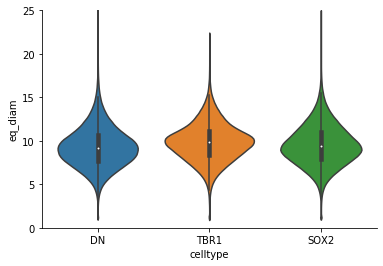

In [46]:
sns.violinplot(x='celltype', y='eq_diam', data=df)
sns.despine()
plt.ylim([0, 25])

plt.savefig(os.path.join(working_dir, 'nuclei_morphology_violin_plots.pdf'), bbox_inches='tight')

plt.show()

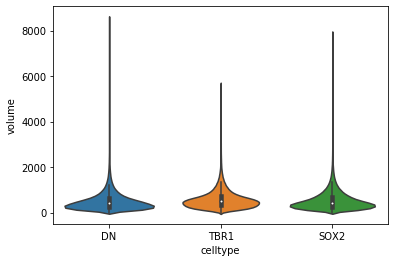

In [11]:
sns.violinplot(x='celltype', y='volume', data=df)
plt.show()

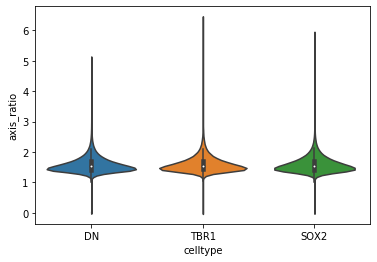

In [12]:
sns.violinplot(x='celltype', y='axis_ratio', data=df)
plt.show()

Try PCA on segmentations

In [13]:
from scout.niche import randomly_sample
from sklearn.decomposition import PCA

In [21]:
seg_sample, celltype_sample = randomly_sample(100_000, seg, np.asarray(celltypes))
seg_sample.shape

(100000, 16, 32, 32)

In [22]:
x = seg_sample.reshape((len(seg_sample), -1))
x.shape

(100000, 16384)

In [23]:
xpca = PCA(n_components=2).fit_transform(x)
xpca.shape

(100000, 2)

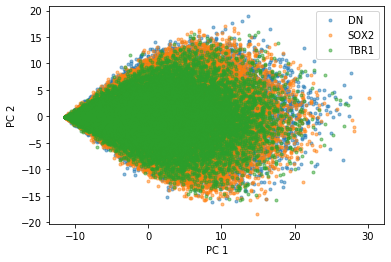

In [42]:
for celltype in np.unique(np.asarray(celltype_sample)):
    if celltype == 'DP':
        continue
    idx = np.where(np.asarray(celltype_sample) == celltype)[0]
    plt.plot(xpca[idx, 0], xpca[idx, 1], '.', label=celltype, alpha=0.5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()

In [29]:
keep_idx = np.where(celltype_sample != 'DP')[0]
seg_sample = seg_sample[keep_idx]
celltype_sample = celltype_sample[keep_idx]
xpca = xpca[keep_idx]
seg_sample.shape, celltype_sample.shape, xpca.shape

((99268, 16, 32, 32), (99268,), (99268, 2))

In [31]:
df2 = pd.DataFrame({'PC 1': xpca[:, 0], 'PC 2': xpca[:, 1], 'cell-type': celltype_sample})
df2.head()

,PC 1,PC 2,cell-type
0,11.112829,-2.273734,DN
1,-7.408497,-1.691815,DN
2,-3.261982,-0.285971,SOX2
3,2.552668,4.896479,SOX2
4,-1.184287,-4.216887,DN


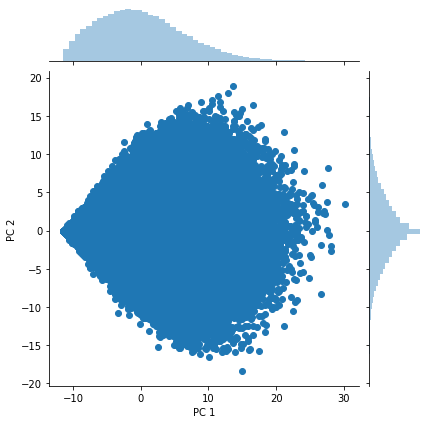

In [38]:
sns.jointplot(x='PC 1', y='PC 2', data=df2)
plt.show()